<center><font size=7 color="#17356B">ANOVA</font></center><br>
<center><font size=5 color="#17356B"><i>Bartosz Dutka <br>Sebastian Bartczak</i></font></center> <br>
<center><font size=5 color="#17356B">Analysis of tracks from Spotify using Spotify Web API and Spotipy Python module</font></center><br>

In [2]:
import pandas as pd
import scipy.stats as stats
import researchpy as rp
import statsmodels.api as sm
from statsmodels.formula.api import ols
import warnings
import numpy as np
import seaborn as sns
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multicomp import MultiComparison
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import pingouin as pg

In [35]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE

<center><font size=5 color="#17356B">Brief peek at the data</font></center>

In [36]:
# warnings.filterwarnings(action='once')
warnings.filterwarnings('ignore')
filename = "../../data/dataset2.csv"
df = pd.read_csv(filename, header=0)
df

,Genre,Length,Popularity,Danceabilty,Energy,Loudness,Speechiness,Acousticness,Instrumentalness,Liveness,Valence,Tempo
0,rap,323,21,0.491,0.523,-9.417,0.5920,0.15500,0.000000,0.4050,0.243,73.790
1,rap,226,23,0.651,0.775,-5.375,0.2980,0.21600,0.000000,0.0783,0.901,83.212
2,rap,162,29,0.791,0.795,-4.188,0.1820,0.23900,0.000004,0.3270,0.581,84.987
3,rap,150,25,0.840,0.530,-5.243,0.4720,0.00590,0.000000,0.1030,0.286,179.919
4,rap,177,26,0.792,0.583,-4.929,0.1190,0.00101,0.000455,0.1170,0.282,151.996
...,...,...,...,...,...,...,...,...,...,...,...,...
5994,rock,268,25,0.474,0.806,-7.950,0.0495,0.06990,0.000203,0.0736,0.390,179.897
5995,rock,233,25,0.583,0.822,-7.908,0.0324,0.03500,0.006470,0.2930,0.497,95.910
5996,rock,242,24,0.641,0.757,-6.889,0.0259,0.06110,0.000097,0.0928,0.646,95.313
5997,rock,155,24,0.560,0.950,-7.158,0.0530,0.04000,0.040100,0.3560,0.663,96.020


<center><font size=7 color="#17356B">One-way anova</font></center>

<center><font size=5 color="#17356B">Functions for basic analysis</font></center>

In [529]:
def ow_anova(df: pd.DataFrame, genres: list = ['rap', 'rock', 'reggae'], alpha: float = 0.05, feature: str = 'Popularity'):
    groups = tuple(df[feature][df['Genre'] == genre] for genre in genres)
    f_st = stats.f_oneway(*groups)
    l_st = stats.levene(*groups)
    if f_st[1] < alpha:
        print("Odrzucamy H0 - srednie się różnią. p-value wynosi %s" % f_st[1])
    else:
        print("Nie odrzucamy H0 - srednie sa zblizone. p-value wynosi %s" % f_st[1])
    return f_st, l_st

In [530]:
def print_table(df: pd.DataFrame, feature: str = 'Popularity'):
    return rp.summary_cont(df[feature].groupby(df['Genre']))

In [644]:
def model(df: pd.DataFrame, feature: str):
    rm = feature + ' ~ C(Genre)'
    results = ols(rm, data=df).fit()
    return results

In [532]:
def anova_table(aov):
    aov['mean_sq'] = aov[:]['sum_sq'] / aov[:]['df']
    aov['eta_sq'] = aov[:-1]['sum_sq'] / sum(aov['sum_sq'])
    aov['omega_sq'] = (aov[:-1]['sum_sq'] - (aov[:-1]['df'] * aov['mean_sq'][-1])) / (
            sum(aov['sum_sq']) + aov['mean_sq'][-1])
    cols = ['sum_sq', 'df', 'mean_sq', 'F', 'PR(>F)', 'eta_sq', 'omega_sq']
    aov = aov[cols]

    return aov

<center><font size=5 color="#17356B">Popularity</font></center>

In [658]:
popularity_f_st, popularity_l_st = ow_anova(df, alpha=0.02)

Odrzucamy H0 - srednie się różnią. p-value wynosi 6.212161308936743e-32


In [649]:
popularity_f_st

F_onewayResult(statistic=370.0109395413718, pvalue=2.9887453811856653e-152)

In [659]:
popularity_l_st

LeveneResult(statistic=21.2499783519175, pvalue=6.365094379746742e-10)

In [660]:
print_table(df)

,N,Mean,SD,SE,95% Conf.,Interval
Genre,,,,,,
rap,2041,24.669770,18.164005,0.402059,23.881540,25.457999
reggae,1145,10.068996,9.485154,0.280312,9.519344,10.618647
rock,2813,23.627800,49.028301,0.924404,21.815645,25.439954


In [661]:
results = model(df, 'Popularity')

In [662]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Popularity   R-squared:                       0.024
Model:                            OLS   Adj. R-squared:                  0.023
Method:                 Least Squares   F-statistic:                     72.72
Date:                Mon, 13 Jan 2020   Prob (F-statistic):           6.21e-32
Time:                        06:51:35   Log-Likelihood:                -29916.
No. Observations:                5999   AIC:                         5.984e+04
Df Residuals:                    5996   BIC:                         5.986e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             24.6698      0.785     31.439      0.000      23.131      26.208
C(Genre)[T.reggae]   -14.6008      1.309    -11.155      0.000     -17.167     -12.035
C(Genre)[T.rock]      -1.0420      1.031     -1.011      0.312      -3.063       0.979
==============================================================================
Omnibus:                    19847.113   Durbin-Watson:                   1.646
Prob(Omnibus):                  0.000   Jarque-Bera (JB):       3943227791.833
Skew:                          56.910   Prob(JB):                         0.00
Kurtosis:                    3973.212   Cond. No.                         3.92
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [663]:
aov_table = sm.stats.anova_lm(results, typ=2)
aov_table

,sum_sq,df,F,PR(>F)
C(Genre),1.827906e+05,2.0,72.724262,6.212161e-32
Residual,7.535396e+06,5996.0,NaN,NaN


In [664]:
anova_table(aov_table)

,sum_sq,df,mean_sq,F,PR(>F),eta_sq,omega_sq
C(Genre),1.827906e+05,2.0,91395.285796,72.724262,6.212161e-32,0.023683,0.023354
Residual,7.535396e+06,5996.0,1256.737205,NaN,NaN,NaN,NaN


<center><font size=5 color="#17356B">Other features</font></center>

In [541]:
def basic_analysis(df: pd.DataFrame, feature: str):
    f_st, l_st = ow_anova(df, alpha=0.02, feature = feature)
    print(f_st)
    print(l_st)
    print(print_table(df, feature = feature))
    results = model(df, feature = feature)
    print(results.summary())
    aov_table = sm.stats.anova_lm(results, typ=2)
    print(aov_table)
    print(anova_table(aov_table))

<center><font size=5 color="#17356B">Length</font></center>

In [542]:
basic_analysis(df, 'Length')

Odrzucamy H0 - srednie się różnią. p-value wynosi 4.143866201253811e-95
F_onewayResult(statistic=225.39465305902075, pvalue=4.143866201253811e-95)
LeveneResult(statistic=138.84093569206178, pvalue=1.1395061966997034e-59)


           N        Mean          SD        SE   95% Conf.    Interval
Genre                                                                 
rap     2041  202.129838   66.166007  1.464581  199.258556  205.001121
reggae  1145  228.762445   70.798822  2.092297  224.659752  232.865139
rock    2813  265.127622  131.971347  2.488254  260.249776  270.005468
                            OLS Regression Results                            
Dep. Variable:                 Length   R-squared:                       0.070
Model:                            OLS   Adj. R-squared:                  0.070
Method:                 Least Squares   F-statistic:                     225.4
Date:                Sun, 12 Jan 2020   Prob (F-statistic):           4.14e-95
Time:                      

<center><font size=5 color="#17356B">Energy</font></center>

In [665]:
basic_analysis(df, 'Energy')

Odrzucamy H0 - srednie się różnią. p-value wynosi 0.0033255278455720304
F_onewayResult(statistic=5.711560581214721, pvalue=0.0033255278455720304)
LeveneResult(statistic=0.6983255554323831, pvalue=0.49745795554959615)


           N      Mean        SD        SE  95% Conf.  Interval
Genre                                                          
rap     2041  0.690184  2.204784  0.048803   0.594507  0.785861
reggae  1145  0.561403  0.157067  0.004642   0.552302  0.570505
rock    2813  0.712592  0.223504  0.004214   0.704331  0.720853
                            OLS Regression Results                            
Dep. Variable:                 Energy   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     5.712
Date:                Mon, 13 Jan 2020   Prob (F-statistic):            0.00333
Time:                        06:51:45   Log-Likelihood:           

<center><font size=5 color="#17356B">Loudness</font></center>

In [544]:
basic_analysis(df, 'Loudness')

Odrzucamy H0 - srednie się różnią. p-value wynosi 7.910963835641652e-33
F_onewayResult(statistic=74.83582316690101, pvalue=7.910963835641652e-33)
LeveneResult(statistic=69.6285316371831, pvalue=1.2779754414579756e-30)


           N      Mean        SD        SE  95% Conf.  Interval
Genre                                                          
rap     2041 -7.477364  3.041893  0.067332  -7.609367 -7.345361
reggae  1145 -9.066973  3.478689  0.102805  -9.268558 -8.865388
rock    2813 -8.288941  3.999783  0.075414  -8.436778 -8.141103
                            OLS Regression Results                            
Dep. Variable:               Loudness   R-squared:                       0.024
Model:                            OLS   Adj. R-squared:                  0.024
Method:                 Least Squares   F-statistic:                     74.84
Date:                Sun, 12 Jan 2020   Prob (F-statistic):           7.91e-33
Time:                        22:01:04   Log-Likelihood:          

<center><font size=5 color="#17356B">Instrumentalness</font></center>

In [545]:
basic_analysis(df, 'Instrumentalness')

Odrzucamy H0 - srednie się różnią. p-value wynosi 2.9679198248739694e-86
F_onewayResult(statistic=203.54661740159847, pvalue=2.9679198248739694e-86)
LeveneResult(statistic=203.74296284559796, pvalue=2.469472772919315e-86)


           N      Mean        SD        SE  95% Conf.  Interval
Genre                                                          
rap     2041  0.010597  0.069837  0.001546   0.007567  0.013628
reggae  1145  0.150923  0.295890  0.008744   0.133776  0.168069
rock    2813  0.112193  0.238709  0.004501   0.103370  0.121016
                            OLS Regression Results                            
Dep. Variable:       Instrumentalness   R-squared:                       0.064
Model:                            OLS   Adj. R-squared:                  0.063
Method:                 Least Squares   F-statistic:                     203.5
Date:                Sun, 12 Jan 2020   Prob (F-statistic):           2.97e-86
Time:                        22:01:04   Log-Likelihood:      

<center><font size=5 color="#17356B">Liveness</font></center>

In [546]:
basic_analysis(df, 'Liveness')

Odrzucamy H0 - srednie się różnią. p-value wynosi 1.0195541562453033e-148
F_onewayResult(statistic=360.88447760231634, pvalue=1.0195541562453033e-148)
LeveneResult(statistic=413.09682981864694, pvalue=8.411376113175055e-169)


           N      Mean        SD        SE  95% Conf.  Interval
Genre                                                          
rap     2041  0.219616  0.177478  0.003928   0.211914  0.227318
reggae  1145  0.179145  0.176973  0.005230   0.168890  0.189401
rock    2813  0.376552  0.312633  0.005895   0.364997  0.388108
                            OLS Regression Results                            
Dep. Variable:               Liveness   R-squared:                       0.107
Model:                            OLS   Adj. R-squared:                  0.107
Method:                 Least Squares   F-statistic:                     360.9
Date:                Sun, 12 Jan 2020   Prob (F-statistic):          1.02e-148
Time:                        22:01:04   Log-Likelihood:   

<center><font size=5 color="#17356B">Danceability</font></center>

In [547]:
basic_analysis(df, 'Danceabilty')

Odrzucamy H0 - srednie się różnią. p-value wynosi 0.0
F_onewayResult(statistic=2286.462341834716, pvalue=0.0)
LeveneResult(statistic=47.06877653878672, pvalue=5.213124107885385e-21)


           N      Mean        SD        SE  95% Conf.  Interval
Genre                                                          
rap     2041  0.707372  0.146454  0.003242   0.701016  0.713727
reggae  1145  0.728311  0.119003  0.003517   0.721415  0.735207
rock    2813  0.464542  0.149967  0.002828   0.458999  0.470085
                            OLS Regression Results                            
Dep. Variable:            Danceabilty   R-squared:                       0.433
Model:                            OLS   Adj. R-squared:                  0.432
Method:                 Least Squares   F-statistic:                     2286.
Date:                Sun, 12 Jan 2020   Prob (F-statistic):               0.00
Time:                        22:01:04   Log-Likelihood:                 3142.5
No. Observations:     

<center><font size=5 color="#17356B">Testing for normality</font></center>

In [656]:
results = model(df, feature='Popularity')
stats.shapiro(results.resid)

(0.9624946713447571, 8.221125274866596e-37)

In [549]:
results = model(df, feature='Length')
stats.shapiro(results.resid)

(0.8076945543289185, 0.0)

In [550]:
results = model(df, feature='Energy')
stats.shapiro(results.resid)

(0.962460994720459, 7.977220420944567e-37)

In [551]:
results = model(df, feature='Loudness')
stats.shapiro(results.resid)

(0.9199243783950806, 0.0)

In [552]:
results = model(df, feature='Instrumentalness')
stats.shapiro(results.resid)

(0.6106445789337158, 0.0)

In [553]:
results = model(df, feature='Liveness')
stats.shapiro(results.resid)

(0.8806784749031067, 0.0)

In [554]:
results = model(df, feature='Danceabilty')
stats.shapiro(results.resid)

(0.9916821122169495, 2.6678318037976098e-18)

<center><font size=5 color="#17356B">Post hoc testing</font></center>

In [629]:
def multi_comparison(feature: str):
    mc = MultiComparison(df[feature], df['Genre'])
    print(mc.tukeyhsd())

In [666]:
multi_comparison('Popularity')

 Multiple Comparison of Means - Tukey HSD, FWER=0.05  
group1 group2 meandiff p-adj   lower    upper   reject
------------------------------------------------------
   rap reggae -14.6008  0.001 -17.6693 -11.5322   True
   rap   rock   -1.042 0.5653  -3.4584   1.3745  False
reggae   rock  13.5588  0.001  10.6455  16.4721   True
------------------------------------------------------


In [557]:
multi_comparison('Length')

Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj  lower   upper  reject
---------------------------------------------------
   rap reggae  26.6326 0.001  17.715 35.5502   True
   rap   rock  62.9978 0.001 55.9753 70.0203   True
reggae   rock  36.3652 0.001 27.8988 44.8316   True
---------------------------------------------------


In [667]:
multi_comparison('Energy')

Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj  lower   upper  reject
---------------------------------------------------
   rap reggae  -0.1288 0.0197 -0.241 -0.0165   True
   rap   rock   0.0224 0.8036 -0.066  0.1108  False
reggae   rock   0.1512 0.0026 0.0446  0.2578   True
---------------------------------------------------


In [559]:
multi_comparison('Loudness')

Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj  lower   upper  reject
---------------------------------------------------
   rap reggae  -1.5896 0.001 -1.9012  -1.278   True
   rap   rock  -0.8116 0.001  -1.057 -0.5662   True
reggae   rock    0.778 0.001  0.4822  1.0739   True
---------------------------------------------------


In [560]:
multi_comparison('Instrumentalness')

Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj  lower   upper  reject
---------------------------------------------------
   rap reggae   0.1403 0.001  0.1219  0.1587   True
   rap   rock   0.1016 0.001  0.0871  0.1161   True
reggae   rock  -0.0387 0.001 -0.0562 -0.0213   True
---------------------------------------------------


In [561]:
multi_comparison('Liveness')

Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj  lower   upper  reject
---------------------------------------------------
   rap reggae  -0.0405 0.001 -0.0621 -0.0188   True
   rap   rock   0.1569 0.001  0.1399   0.174   True
reggae   rock   0.1974 0.001  0.1769   0.218   True
---------------------------------------------------


In [562]:
multi_comparison('Danceabilty')

Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj  lower   upper  reject
---------------------------------------------------
   rap reggae   0.0209 0.001  0.0085  0.0333   True
   rap   rock  -0.2428 0.001 -0.2526 -0.2331   True
reggae   rock  -0.2638 0.001 -0.2755  -0.252   True
---------------------------------------------------


<center><font size=5 color="#17356B">Plotting regression models</font></center>

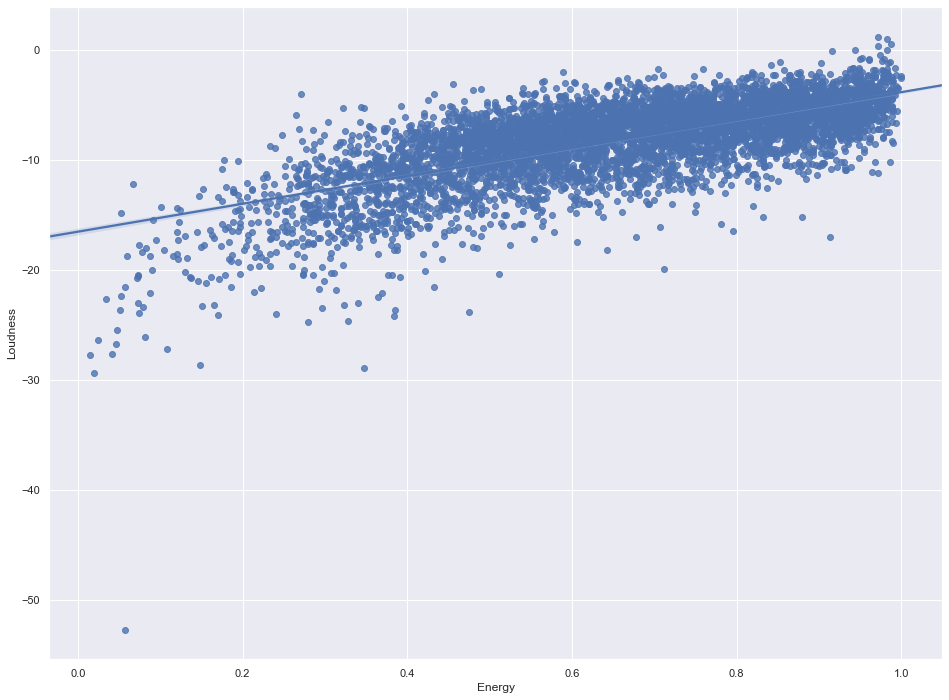

In [563]:
sns.set()
plt.rcParams["figure.figsize"] = (16,12)
sns.regplot(x=df['Energy'], y=df['Loudness'], data=df)
# loudness(instrumentalness)
# danceability(liveness)

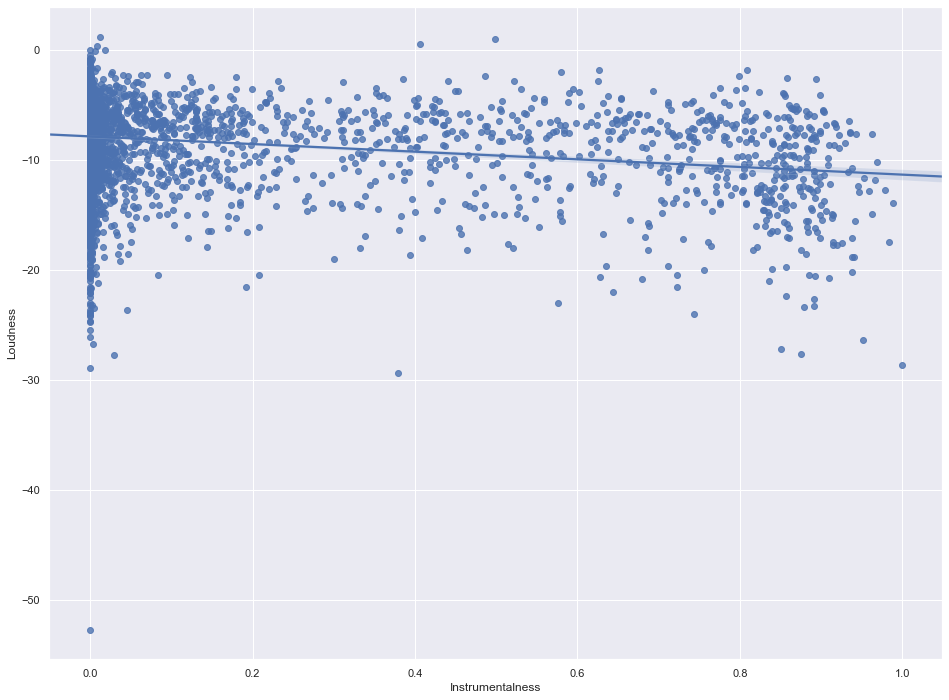

In [564]:
sns.regplot(x=df['Instrumentalness'], y=df['Loudness'], data=df)

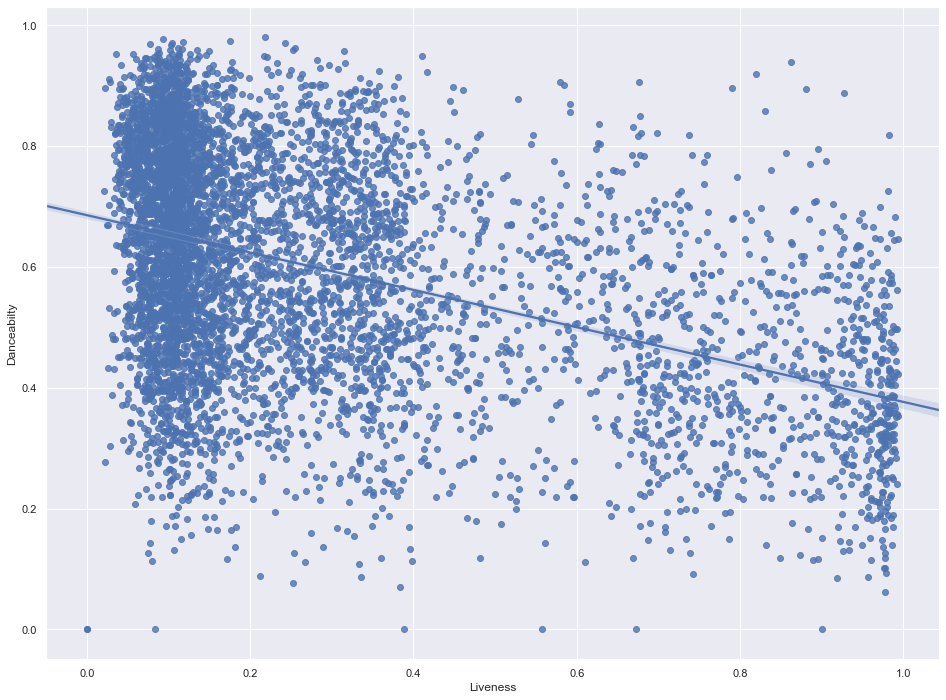

In [565]:
sns.regplot(x=df['Liveness'], y=df['Danceabilty'], data=df)

<center><font size=5 color="#17356B">Plotting distributions</font></center>

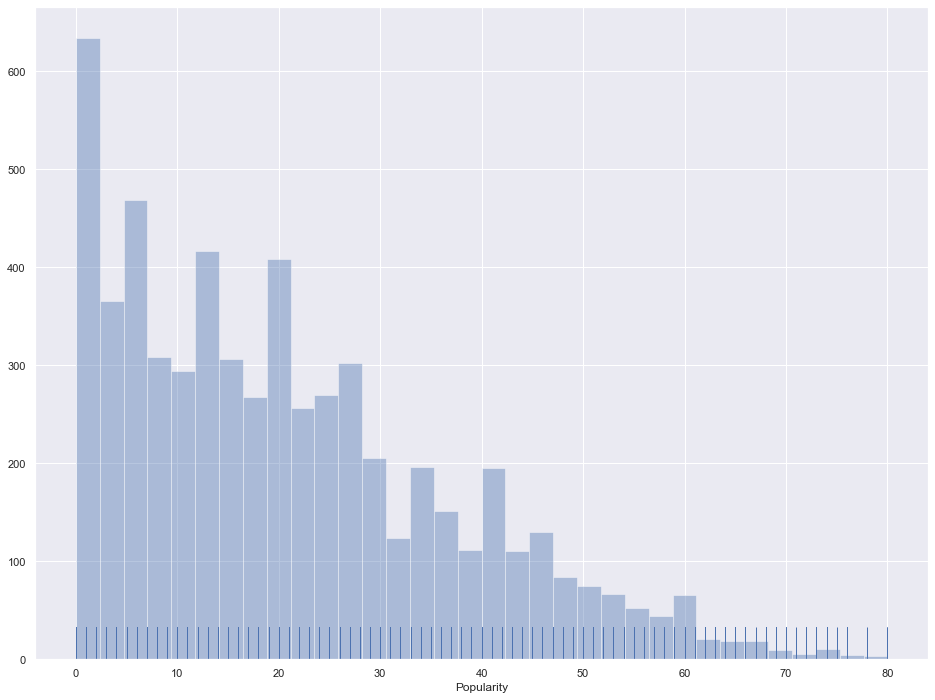

In [566]:
sns.set(color_codes=True)
sns.distplot(df['Popularity'], kde=False, rug=True)
# sns.distplot(df['Popularity'][df['Genre']=='rap'], kde=False, rug=True)

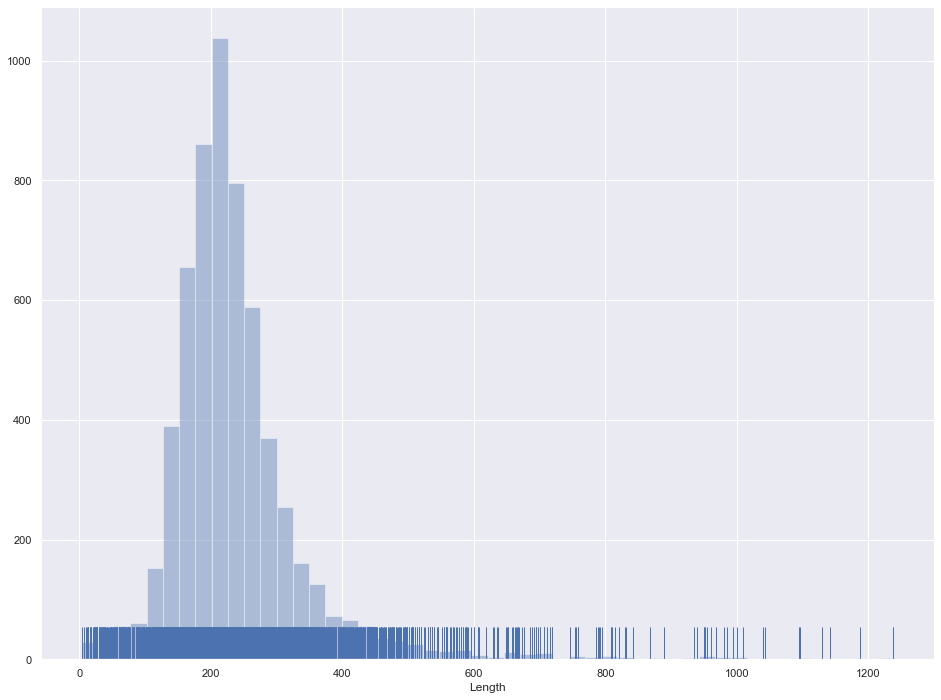

In [567]:
sns.distplot(df['Length'], kde=False, rug=True)

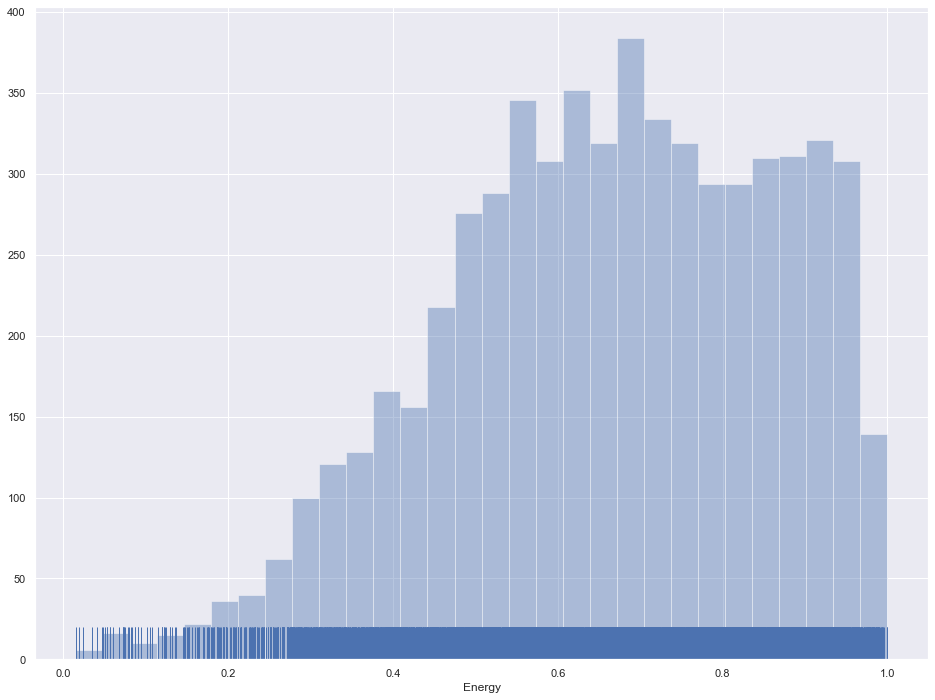

In [568]:
sns.distplot(df['Energy'], kde=False, rug=True)

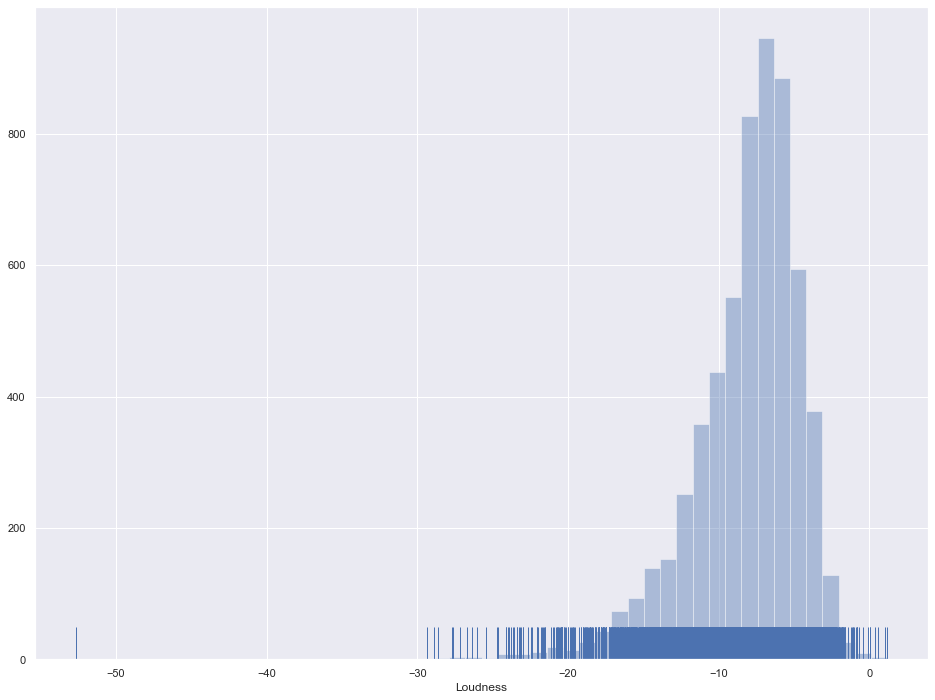

In [569]:
sns.distplot(df['Loudness'], kde=False, rug=True)

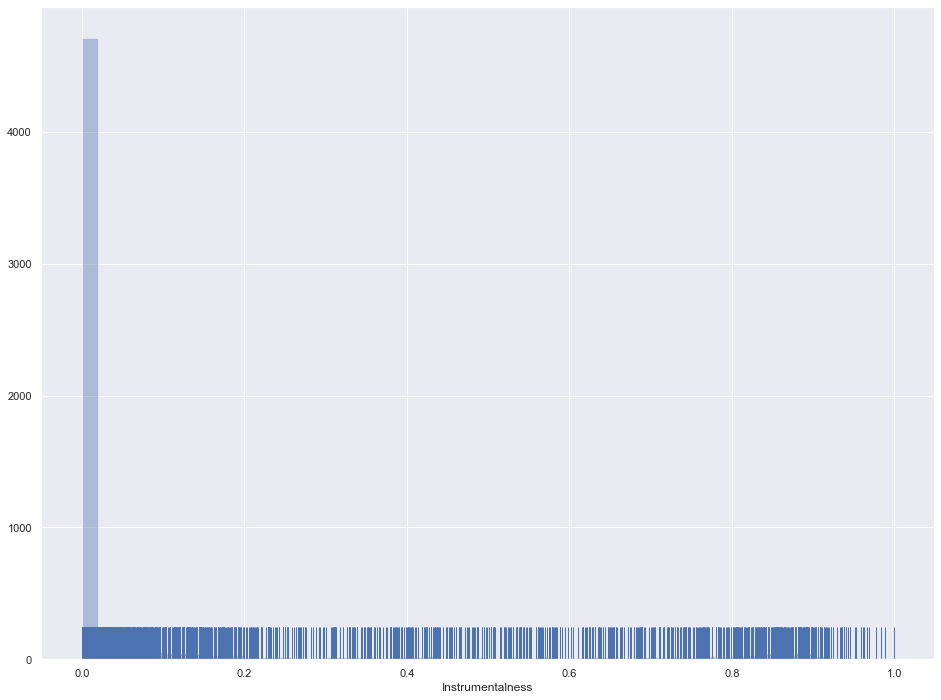

In [570]:
sns.distplot(df['Instrumentalness'], kde=False, rug=True)

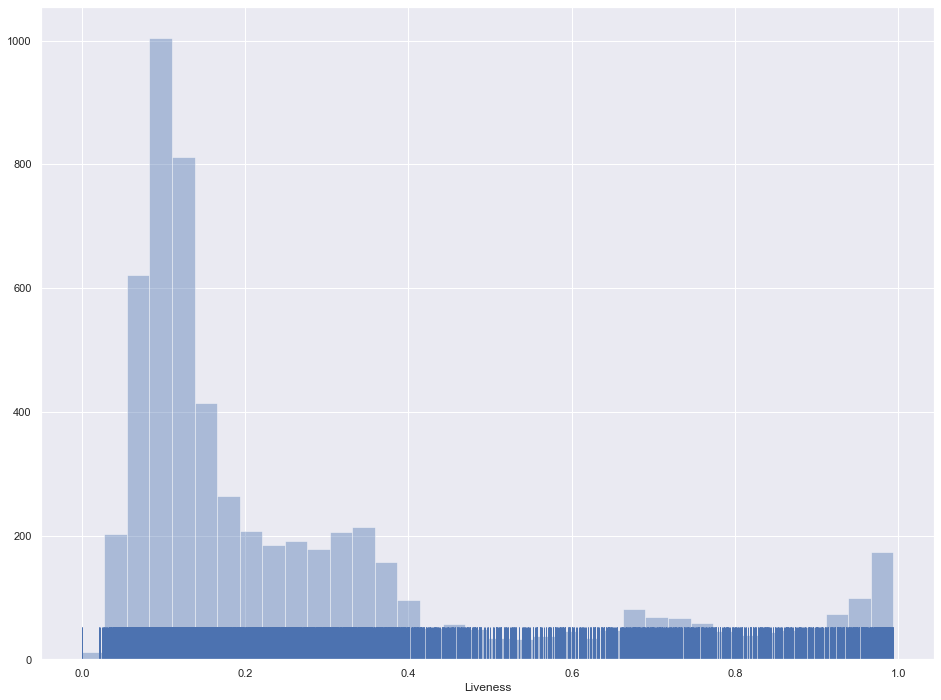

In [571]:
sns.distplot(df['Liveness'], kde=False, rug=True)

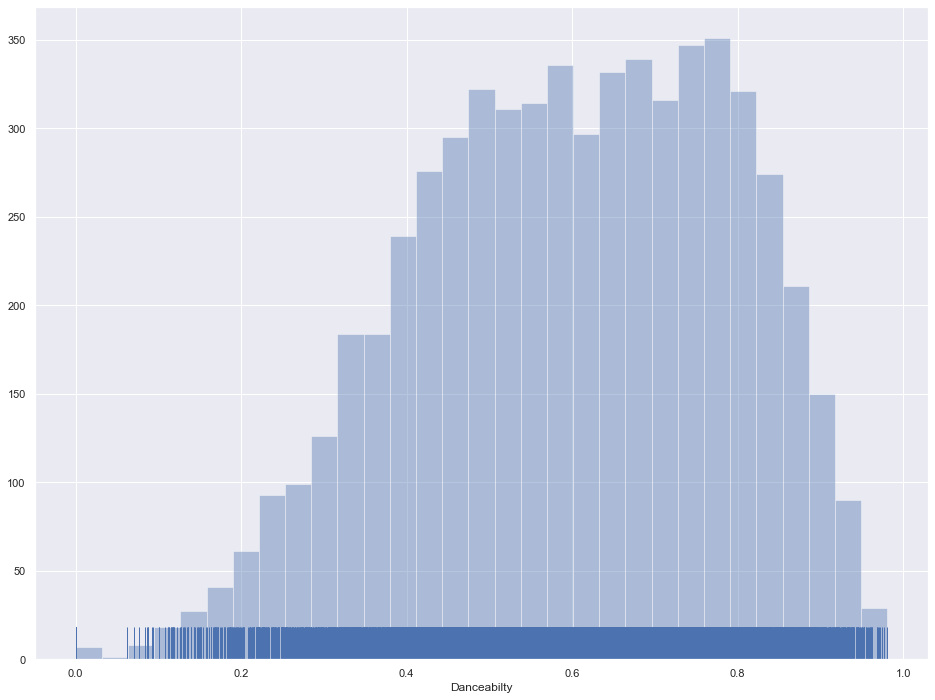

In [572]:
sns.distplot(df['Danceabilty'], kde=False, rug=True)

<center><font size=7 color="#17356B">PCA</font></center>

In [573]:
pca_df = df.drop('Genre', axis=1)
pca = PCA(n_components=2)
pca.fit(pca_df)
print("Explained Variance: %s" % pca.explained_variance_ratio_)
print("Components: %s" % pca.components_)

Explained Variance: [0.90545697 0.07269597]
Components: [[ 9.99996571e-01 -2.35685166e-03 -4.76877545e-04  1.66657122e-04
  -4.61448442e-04 -2.90429522e-04 -2.03784413e-04  1.00529435e-04
   5.23543689e-04 -3.27409688e-04  5.62944257e-04]
 [ 4.80474438e-04 -3.32055786e-02  4.71759380e-04 -8.83488975e-04
  -9.74264662e-03  1.38920305e-04  9.93297043e-04 -2.40368483e-04
  -1.19413734e-04 -2.41084675e-04 -9.99399870e-01]]


In [578]:
scaler = StandardScaler()
scaler.fit(pca_df)
scaled_data = scaler.transform(pca_df)
pca = PCA(n_components=2)
pca.fit(scaled_data)
x_pca = pca.transform(scaled_data)
print(scaled_data.shape)
print(x_pca.shape)

(5999, 11)
(5999, 2)


Text(0, 0.5, 'Second Principal Component')

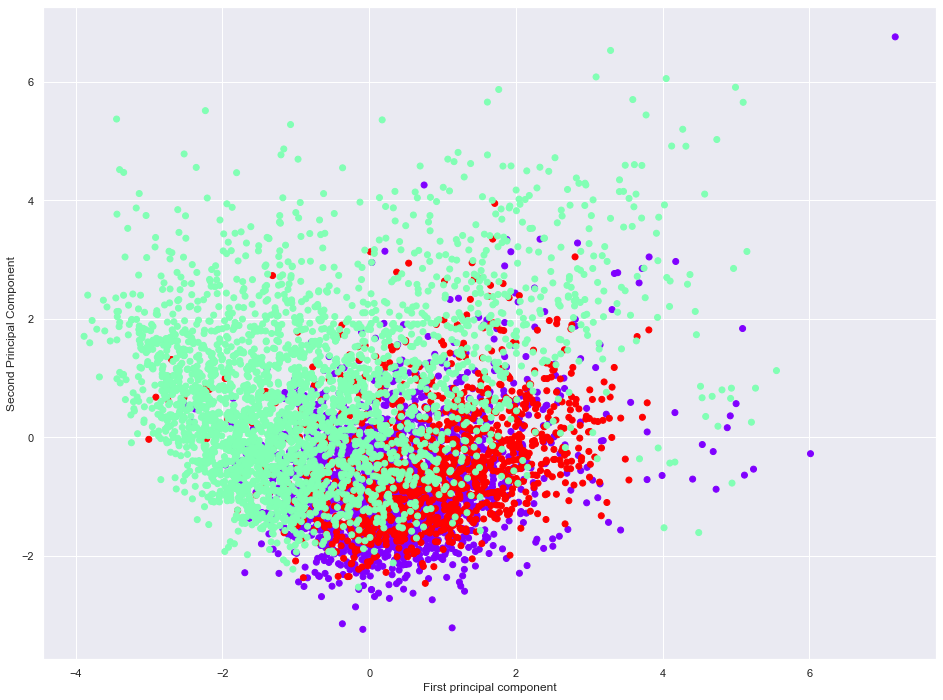

In [603]:
plt.figure(figsize=(16,12))
# df['Genre'].replace({'rap': 0, "rock": 1, "reggae": 2}, inplace= True)
plt.scatter(x_pca[:,0],x_pca[:,1],c=df['Genre'],cmap='rainbow')
plt.xlabel('First principal component')
plt.ylabel('Second Principal Component')

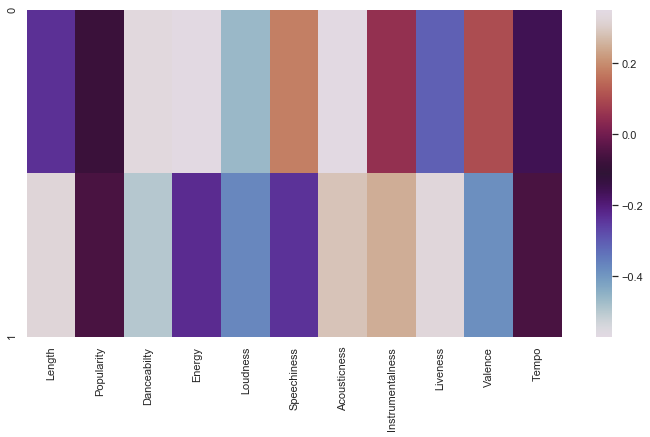

In [577]:
feature_names = ['Length','Popularity','Danceabilty','Energy','Loudness','Speechiness','Acousticness','Instrumentalness','Liveness','Valence','Tempo']
map= pd.DataFrame(pca.components_,columns=feature_names)
plt.figure(figsize=(12,6))
sns.heatmap(map,cmap='twilight')

<center><font size=7 color="#17356B">Two-way anova</font></center>

In [793]:
df['Genre'].replace({0: 'rap', 1: "rock", 2: "reggae"}, inplace= True)
# rp.summary_cont(df['Loudness'])

In [623]:
def plot_class(df: pd.DataFrame, feature: str):
    sns.set()
    plt.plot([i for i in range(len(df[feature]))], df[feature])
    plt.legend([feature], ncol=2, loc='upper left', prop={'size': 30})
    plt.rcParams["figure.figsize"] = (30,15)
    plt.show()

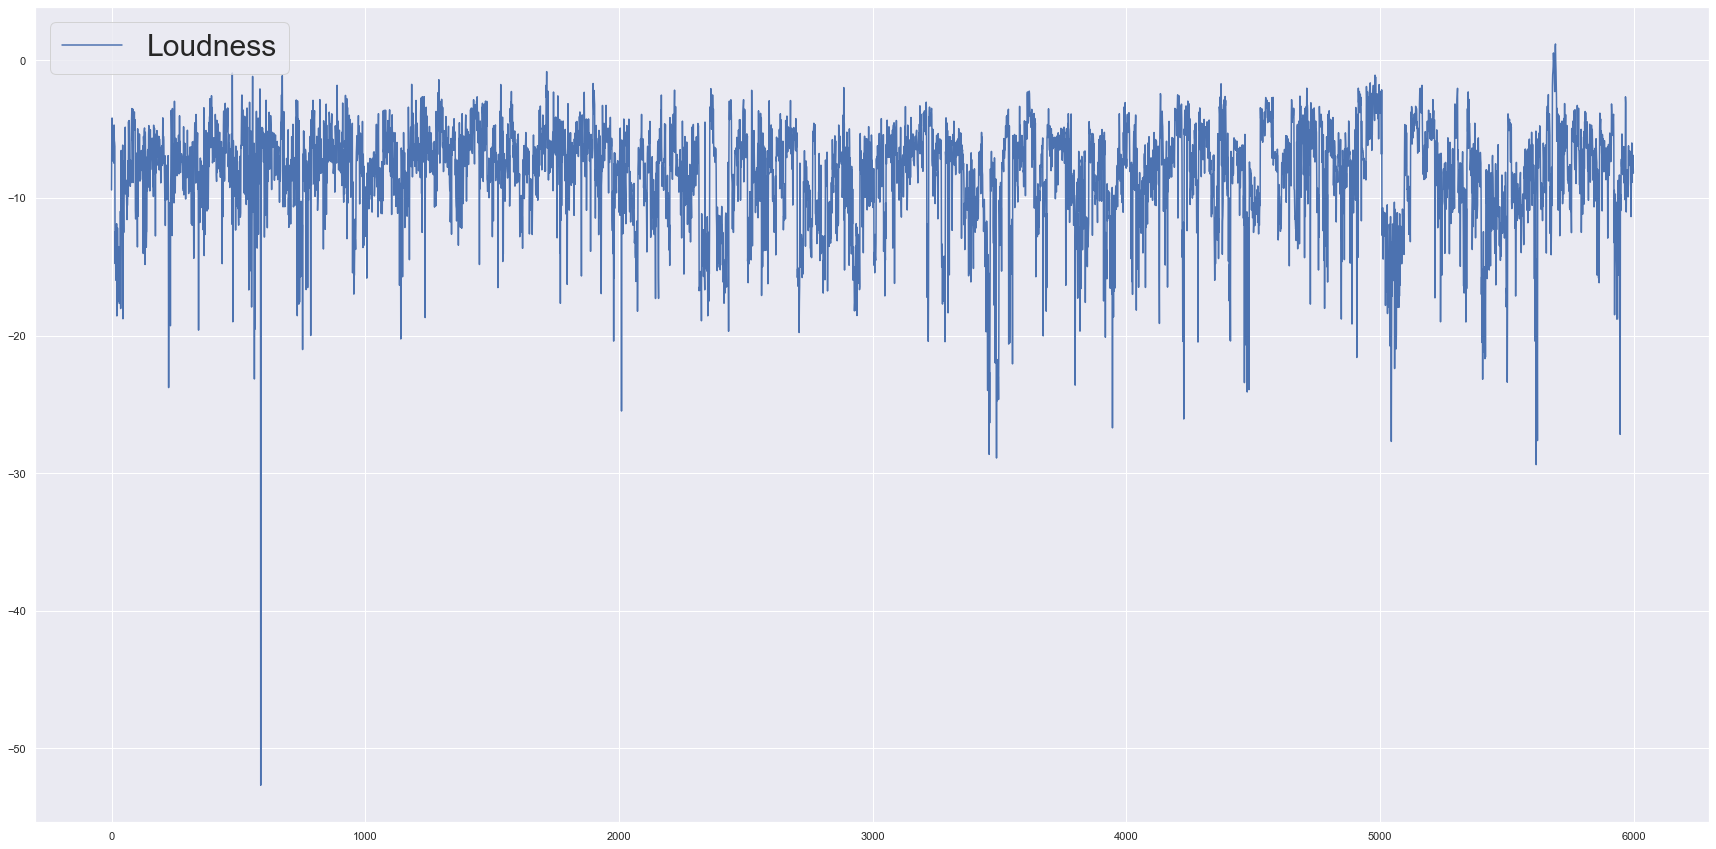

In [626]:
plot_class(df, "Loudness")

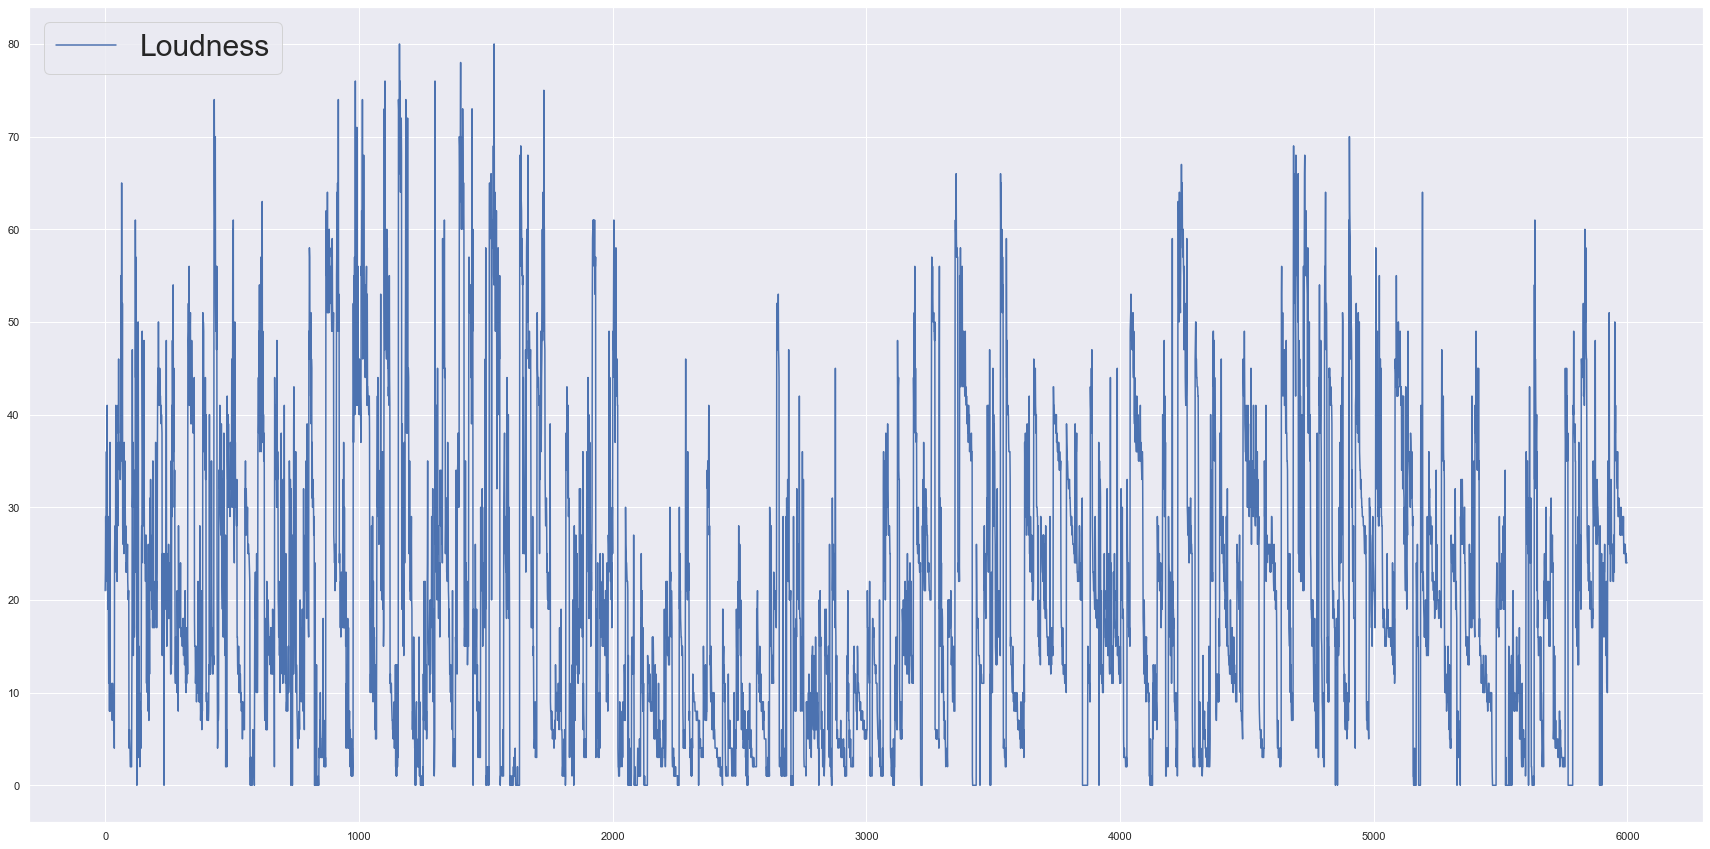

In [627]:
plot_class(df, "Popularity")

In [90]:
df_twa = df

for i in range(len(df_twa['Liveness'])):
    if df_twa['Liveness'][i]<0.4:
        df_twa['Liveness'][i] = 'studio'
    elif df_twa['Liveness'][i] >= 0.4 and df_twa['Liveness'][i] < 0.9:
        df_twa['Liveness'][i] = 'cant_tell'
    else:
        df_twa['Liveness'][i] = 'live'

In [92]:
aov = pg.anova(dv='Popularity', between=['Genre', 'Liveness'], data=df_twa, detailed=True)
print(aov)

             Source           SS      DF         MS       F         p-unc  \
0             Genre   198552.930     2.0  99276.465  79.155  1.175034e-34   
1          Liveness    20958.851     2.0  10479.425   8.355  2.378766e-04   
2  Genre * Liveness     2326.150     4.0    581.537   0.464  7.624620e-01   
3          Residual  7512724.771  5990.0   1254.211     NaN           NaN   

     np2  
0  0.026  
1  0.003  
2  0.000  
3    NaN  


In [93]:
formula = 'Popularity ~ C(Genre) + C(Liveness) + C(Genre)*C(Liveness)'
model = ols(formula, df_twa).fit()
aov_table = anova_lm(model, typ=2)
print(aov_table.round(4))

                            sum_sq      df        F  PR(>F)
C(Genre)              1.985529e+05     2.0  79.1545  0.0000
C(Liveness)           2.095885e+04     2.0   8.3554  0.0002
C(Genre):C(Liveness)  2.326150e+03     4.0   0.4637  0.7625
Residual              7.512725e+06  5990.0      NaN     NaN


In [94]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Popularity   R-squared:                       0.027
Model:                            OLS   Adj. R-squared:                  0.025
Method:                 Least Squares   F-statistic:                     20.56
Date:                Tue, 14 Jan 2020   Prob (F-statistic):           5.26e-31
Time:                        01:13:26   Log-Likelihood:                -29907.
No. Observations:                5999   AIC:                         5.983e+04
Df Residuals:                    5990   BIC:                         5.989e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
============================================================================================================
                                               coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------
Intercept                                   21.9915      2.310      9.519      0.000      17.463      26.520
C(Genre)[T.reggae]                         -14.2772      5.562     -2.567      0.010     -25.180      -3.374
C(Genre)[T.rock]                            -1.5739      2.710     -0.581      0.561      -6.886       3.739
C(Liveness)[T.live]                        -10.8665      9.150     -1.188      0.235     -28.804       7.071
C(Liveness)[T.studio]                        3.1510      2.457      1.282      0.200      -1.666       7.968
C(Genre)[T.reggae]:C(Liveness)[T.live]      12.5000     12.800      0.977      0.329     -12.594      37.594
C(Genre)[T.rock]:C(Liveness)[T.live]        10.0471      9.462      1.062      0.288      -8.501      28.595
C(Genre)[T.reggae]:C(Liveness)[T.studio]    -0.6733      5.727     -0.118      0.906     -11.901      10.554
C(Genre)[T.rock]:C(Liveness)[T.studio]       1.8789      2.953      0.636      0.525      -3.910       7.668
==============================================================================
Omnibus:                    19862.621   Durbin-Watson:                   1.705
Prob(Omnibus):                  0.000   Jarque-Bera (JB):       3967649281.795
Skew:                          57.039   Prob(JB):                         0.00
Kurtosis:                    3985.490   Cond. No.                         54.6
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [42]:
rp.summary_cont(df_twa.groupby(['Genre']))['Popularity']

,N,Mean,SD,SE,95% Conf.,Interval
Genre,,,,,,
rap,2041,24.669770,18.164005,0.402059,23.881733,25.457806
reggae,1145,10.068996,9.485154,0.280312,9.519584,10.618407
rock,2813,23.641664,49.030526,0.924446,21.829749,25.453578


In [43]:
rp.summary_cont(df_twa.groupby(['Liveness']))['Popularity']

,N,Mean,SD,SE,95% Conf.,Interval
Liveness,,,,,,
cant_tell,909,20.139714,15.247707,0.505735,19.148474,21.130954
live,370,18.594595,11.046488,0.574280,17.469007,19.720183
studio,4720,21.863771,39.753088,0.578629,20.729659,22.997883


In [44]:
rp.summary_cont(df_twa.groupby(['Genre', 'Liveness']))['Popularity']

N       Mean         SD        SE  95% Conf.   Interval
Genre  Liveness                                                             
rap    cant_tell   235  21.991489  17.715702  1.155645  19.726425  24.256553
       live         16  11.125000  11.563592  2.890898   5.458840  16.791160
       studio     1790  25.142458  18.200066  0.430176  24.299313  25.985604
reggae cant_tell    49   7.714286   7.271520  1.038789   5.678260   9.750311
       live         23   9.347826   6.499012  1.355138   6.691756  12.003896
       studio     1073  10.191985   9.617520  0.293605   9.616520  10.767451
rock   cant_tell   625  20.417600  14.249719  0.569989  19.300422  21.534778
       live        331  19.598187  10.857138  0.596762  18.428533  20.767841
       studio     1857  25.447496  59.526043  1.381341  22.740067  28.154925

In [46]:
mc = MultiComparison(df_twa['Popularity'], df_twa['Genre'])
print(mc.tukeyhsd())

 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj  lower    upper   reject
-----------------------------------------------------
   rap reggae -14.6008 0.001 -17.6694 -11.5321   True
   rap   rock  -1.0281 0.573  -3.4447   1.3884  False
reggae   rock  13.5727 0.001  10.6593  16.4861   True
-----------------------------------------------------


In [47]:
mc = MultiComparison(df_twa['Popularity'], df_twa['Liveness'])
print(mc.tukeyhsd())

 Multiple Comparison of Means - Tukey HSD, FWER=0.05  
  group1  group2 meandiff p-adj   lower  upper  reject
------------------------------------------------------
cant_tell   live  -1.5451 0.7439 -6.7303   3.64  False
cant_tell studio   1.7241 0.3815 -1.3215 4.7697  False
     live studio   3.2692   0.21 -1.2702 7.8086  False
------------------------------------------------------


In [74]:
df = pd.read_csv(filename, header=0)
df_twa_2 = df
for i in range(len(df_twa_2['Liveness'])):
    if df_twa_2['Liveness'][i] > 0.4 and df_twa_2['Liveness'][i] < 0.9:
        df_twa_2 = df_twa_2.drop(index=i)

In [75]:
df_twa_2 = df_twa_2.reset_index(drop=True)

In [76]:
for j in range(len(df_twa_2['Genre'])):
    if df_twa_2['Genre'][j] == 'rap':
        df_twa_2 = df_twa_2.drop(index=j)

In [77]:
df_twa_2 = df_twa_2.reset_index(drop=True)

In [79]:
for i in range(len(df_twa_2['Liveness'])):
    if df_twa_2['Liveness'][i]<0.4:
        df_twa_2['Liveness'][i] = 'studio'
    else:
        df_twa_2['Liveness'][i] = 'live'

In [82]:
df_twa_2

,Genre,Length,Popularity,Danceabilty,Energy,Loudness,Speechiness,Acousticness,Instrumentalness,Liveness,Valence,Tempo
0,reggae,235,9,0.848,0.414,-9.889,0.1850,0.000357,0.475000,studio,0.497,82.632
1,reggae,219,8,0.844,0.303,-11.005,0.1480,0.011400,0.764000,studio,0.729,84.891
2,reggae,221,7,0.936,0.406,-8.063,0.0854,0.013600,0.026000,studio,0.863,120.740
3,reggae,219,8,0.853,0.407,-9.855,0.1430,0.000056,0.242000,studio,0.719,141.387
4,reggae,220,7,0.815,0.331,-9.312,0.3070,0.007370,0.011700,studio,0.475,150.015
...,...,...,...,...,...,...,...,...,...,...,...,...
3280,rock,268,25,0.474,0.806,-7.950,0.0495,0.069900,0.000203,studio,0.390,179.897
3281,rock,233,25,0.583,0.822,-7.908,0.0324,0.035000,0.006470,studio,0.497,95.910
3282,rock,242,24,0.641,0.757,-6.889,0.0259,0.061100,0.000097,studio,0.646,95.313
3283,rock,155,24,0.560,0.950,-7.158,0.0530,0.040000,0.040100,studio,0.663,96.020


In [83]:
formula = 'Popularity ~ C(Genre) + C(Liveness) + C(Genre)*C(Liveness)'
model = ols(formula, df_twa_2).fit()
aov_table = anova_lm(model, typ=2)
print(aov_table.round(4))

                            sum_sq      df        F  PR(>F)
C(Genre)              1.600061e+05     1.0  78.1751  0.0000
C(Liveness)           9.135640e+03     1.0   4.4634  0.0347
C(Genre):C(Liveness)  5.227097e+02     1.0   0.2554  0.6133
Residual              6.715443e+06  3281.0      NaN     NaN


In [84]:
rp.summary_cont(df_twa_2.groupby(['Genre']))['Popularity']

,N,Mean,SD,SE,95% Conf.,Interval
Genre,,,,,,
reggae,1096,10.174270,9.561229,0.288807,9.608207,10.740333
rock,2189,24.560073,55.026167,1.176106,22.254906,26.865240


In [85]:
rp.summary_cont(df_twa_2.groupby(['Liveness']))['Popularity']

,N,Mean,SD,SE,95% Conf.,Interval
Liveness,,,,,,
live,355,18.932394,10.903840,0.578716,17.798112,20.066677
studio,2930,19.860751,48.302998,0.892360,18.111725,21.609777


In [101]:
rp.summary_cont(df_twa_2.groupby(['Genre', 'Liveness']))['Popularity']

N       Mean         SD        SE  95% Conf.   Interval
Genre  Liveness                                                            
reggae live        23   9.347826   6.499012  1.355138   6.691756  12.003896
       studio    1073  10.191985   9.617520  0.293605   9.616520  10.767451
rock   live       332  19.596386  10.840775  0.594965  18.430254  20.762517
       studio    1857  25.447496  59.526043  1.381341  22.740067  28.154925

In [37]:
df = pd.read_csv(filename, header=0)
df_twa_2 = df
# for i in range(len(df_twa_2['Liveness'])):
#     if df_twa_2['Liveness'][i] > 0.4 and df_twa_2['Liveness'][i] < 0.9:
#         df_twa_2 = df_twa_2.drop(index=i)
# df_twa_2 = df_twa_2.reset_index(drop=True)
for j in range(len(df_twa_2['Genre'])):
    if df_twa_2['Genre'][j] == 'rap':
        df_twa_2 = df_twa_2.drop(index=j)
df_twa_2 = df_twa_2.reset_index(drop=True)
# for i in range(len(df_twa_2['Liveness'])):
#     if df_twa_2['Liveness'][i]<0.4:
#         df_twa_2['Liveness'][i] = 1
#     else:
#         df_twa_2['Liveness'][i] = 0
df_twa_2

,Genre,Length,Popularity,Danceabilty,Energy,Loudness,Speechiness,Acousticness,Instrumentalness,Liveness,Valence,Tempo
0,reggae,235,9,0.848,0.414,-9.889,0.1850,0.000357,0.475000,0.1030,0.497,82.632
1,reggae,219,8,0.844,0.303,-11.005,0.1480,0.011400,0.764000,0.0633,0.729,84.891
2,reggae,221,7,0.936,0.406,-8.063,0.0854,0.013600,0.026000,0.0700,0.863,120.740
3,reggae,219,8,0.853,0.407,-9.855,0.1430,0.000056,0.242000,0.0646,0.719,141.387
4,reggae,220,7,0.815,0.331,-9.312,0.3070,0.007370,0.011700,0.1510,0.475,150.015
...,...,...,...,...,...,...,...,...,...,...,...,...
3953,rock,268,25,0.474,0.806,-7.950,0.0495,0.069900,0.000203,0.0736,0.390,179.897
3954,rock,233,25,0.583,0.822,-7.908,0.0324,0.035000,0.006470,0.2930,0.497,95.910
3955,rock,242,24,0.641,0.757,-6.889,0.0259,0.061100,0.000097,0.0928,0.646,95.313
3956,rock,155,24,0.560,0.950,-7.158,0.0530,0.040000,0.040100,0.3560,0.663,96.020


In [38]:
df_twa_2['Genre'].replace({"reggae": 0, "rock": 1}, inplace= True)

In [28]:
for i in range(len(df_twa_2['Energy'])):
    if df_twa_2['Energy'][i]<0.5:
        df_twa_2['Energy'][i] = 0
    else:
        df_twa_2['Energy'][i] = 1

In [29]:
df_twa_2

,Genre,Length,Popularity,Danceabilty,Energy,Loudness,Speechiness,Acousticness,Instrumentalness,Liveness,Valence,Tempo
0,0,235,9,0.848,0.0,-9.889,0.1850,0.000357,0.475000,1.0,0.497,82.632
1,0,219,8,0.844,0.0,-11.005,0.1480,0.011400,0.764000,1.0,0.729,84.891
2,0,221,7,0.936,0.0,-8.063,0.0854,0.013600,0.026000,1.0,0.863,120.740
3,0,219,8,0.853,0.0,-9.855,0.1430,0.000056,0.242000,1.0,0.719,141.387
4,0,220,7,0.815,0.0,-9.312,0.3070,0.007370,0.011700,1.0,0.475,150.015
...,...,...,...,...,...,...,...,...,...,...,...,...
3280,1,268,25,0.474,1.0,-7.950,0.0495,0.069900,0.000203,1.0,0.390,179.897
3281,1,233,25,0.583,1.0,-7.908,0.0324,0.035000,0.006470,1.0,0.497,95.910
3282,1,242,24,0.641,1.0,-6.889,0.0259,0.061100,0.000097,1.0,0.646,95.313
3283,1,155,24,0.560,1.0,-7.158,0.0530,0.040000,0.040100,1.0,0.663,96.020


In [30]:
X = df_twa_2[['Liveness', 'Energy']]
y = df_twa_2['Genre']

In [17]:
X

,Liveness,Energy
0,1.0,0.0
1,1.0,0.0
2,1.0,0.0
3,1.0,0.0
4,1.0,0.0
...,...,...
3280,1.0,1.0
3281,1.0,1.0
3282,1.0,1.0
3283,1.0,1.0


In [18]:
logit_model=sm.Logit(y,X)
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.618422
         Iterations 5
                         Results: Logit
Model:              Logit            Pseudo R-squared: 0.029     
Dependent Variable: Genre            AIC:              4067.0327 
Date:               2020-01-19 22:01 BIC:              4079.2270 
No. Observations:   3285             Log-Likelihood:   -2031.5   
Df Model:           1                LL-Null:          -2091.6   
Df Residuals:       3283             LLR p-value:      5.5763e-28
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     5.0000                                       
------------------------------------------------------------------
               Coef.   Std.Err.     z     P>|z|    [0.025   0.975]
------------------------------------------------------------------
Liveness      -0.2793    0.0641  -4.3602  0.0000  -0.4049  -0.1538
Energy         1.1663    0.0722  16.1562  0.0000   1.0248   1.

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [23]:
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.64


In [31]:
for i in range(len(df_twa_2['Popularity'])):
    if df_twa_2['Popularity'][i]<10:
        df_twa_2['Popularity'][i] = 0
    elif df_twa_2['Popularity'][i]<30:
        df_twa_2['Popularity'][i] = 1
    elif df_twa_2['Popularity'][i]<50:
        df_twa_2['Popularity'][i] = 2
    elif df_twa_2['Popularity'][i]<60:
        df_twa_2['Popularity'][i] = 3
    elif df_twa_2['Popularity'][i]<=100:
        df_twa_2['Popularity'][i] = 4
# 0-10, 10-30, 30-50, 50-60, 60-80
df_twa_2

,Genre,Length,Popularity,Danceabilty,Energy,Loudness,Speechiness,Acousticness,Instrumentalness,Liveness,Valence,Tempo
0,0,235,0,0.848,0.0,-9.889,0.1850,0.000357,0.475000,1.0,0.497,82.632
1,0,219,0,0.844,0.0,-11.005,0.1480,0.011400,0.764000,1.0,0.729,84.891
2,0,221,0,0.936,0.0,-8.063,0.0854,0.013600,0.026000,1.0,0.863,120.740
3,0,219,0,0.853,0.0,-9.855,0.1430,0.000056,0.242000,1.0,0.719,141.387
4,0,220,0,0.815,0.0,-9.312,0.3070,0.007370,0.011700,1.0,0.475,150.015
...,...,...,...,...,...,...,...,...,...,...,...,...
3280,1,268,1,0.474,1.0,-7.950,0.0495,0.069900,0.000203,1.0,0.390,179.897
3281,1,233,1,0.583,1.0,-7.908,0.0324,0.035000,0.006470,1.0,0.497,95.910
3282,1,242,1,0.641,1.0,-6.889,0.0259,0.061100,0.000097,1.0,0.646,95.313
3283,1,155,1,0.560,1.0,-7.158,0.0530,0.040000,0.040100,1.0,0.663,96.020


In [32]:
X = df_twa_2[['Liveness', 'Energy', 'Popularity']]
y = df_twa_2['Genre']
logit_model=sm.Logit(y,X)
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.509972
         Iterations 9
                          Results: Logit
Model:              Logit            Pseudo R-squared: 0.199      
Dependent Variable: Genre            AIC:              3356.5147  
Date:               2020-01-19 22:12 BIC:              3374.8061  
No. Observations:   3285             Log-Likelihood:   -1675.3    
Df Model:           2                LL-Null:          -2091.6    
Df Residuals:       3282             LLR p-value:      1.4678e-181
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     9.0000                                        
-------------------------------------------------------------------
               Coef.   Std.Err.     z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
Liveness      -1.1867    0.0834  -14.2313  0.0000  -1.3501  -1.0232
Energy         0.8176    0.0843    9.7018  0.0000

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [34]:
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.75


In [39]:
data_final_vars=df_twa_2.columns.values.tolist()
y=['Genre']
X=[i for i in data_final_vars if i not in y]

logreg = LogisticRegression()
rfe = RFE(logreg, 20)
rfe = rfe.fit(os_data_X, os_data_y.values.ravel())
print(rfe.support_)
print(rfe.ranking_)

NameError: name 'os_data_X' is not defined